In [3]:
# !pip install transformers
# !pip install sentencepiece

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [3]:
import numpy as np
import pandas as pd
import transformers
import torch.nn as nn
import torch
import string
import re

from torch import cuda
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

# Read data

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/data/toxic/'
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
# Load train data
df = pd.read_csv(path+'train.csv')
LABEL_COLUMNS = df.columns.tolist()[2:]

In [7]:
# Load test data
test_df = pd.read_csv(path+'test.csv')
test_labels_df = pd.read_csv(path+'test_labels.csv')
test_df = test_df.merge(test_labels_df, on='id', how='left')
test_label_cols = list(test_df.columns[2:])

test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values

# Preprocessing

In [8]:
# # Preprocess text using lemmatization and word tokenization
def clean(text):
    # remove emojis
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    # remove links and hashtags
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    text = " ".join(word.strip() for word in re.split('#|_', text)) #remove hashtags symbol from words in the middle of the sentence
    return text

def clean_df(df):
  rows = []
  for idx in tqdm(range(len(df))):
      row = df.iloc[idx].copy()
      
      # first we remove numeric characters and lowercase everything
      # cleaned_headline = re.sub("[^A-Za-z]+", ' ', row['comment_text'].replace('<br />', ' ')).lower()
      cleaned_headline = clean(row['comment_text'])

      if len(cleaned_headline) > 1:
          row['comment_text'] = cleaned_headline
      rows.append(row)
  df = pd.DataFrame(rows)
  return df

In [9]:
Clean train text and write to new file
df = clean_df(df)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/toxic/toxic_cleaned.csv', index=False)

In [10]:
Clean test text and write to new file
test_df = clean_df(test_df)
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data/toxic/toxic_cleaned_test.csv', index=False)

In [11]:
# Read cleaned data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/toxic/toxic_cleaned.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/toxic/toxic_cleaned_test.csv')

In [12]:
# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2)
train_df.shape, val_df.shape, test_df.shape #test hs only ids and comment_text

((127656, 8), (31915, 8), (63978, 8))

# Dataset 

In [13]:
# Define Dataset
class ToxicCommentsDataset(Dataset):
    def __init__(self, data, tokenizer, max_token_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        
    
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        comment_text = row['comment_text']
        labels = row[LABEL_COLUMNS]
        
        encoding = self.tokenizer.encode_plus(
            comment_text,
            max_length=self.max_token_len,
            padding="max_length",
            truncation=True,
            add_special_tokens=True, # [CLS] & [SEP]
            return_token_type_ids=False,
            return_attention_mask=True, #attention_mask
            return_tensors='pt',
        )
        
        return dict(
            comment_text=comment_text,
            input_ids = encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )

        

# Model 

In [ ]:
# Define the model
class ToxicModel(nn.Module):
    def __init__(self, n_classes, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = transformers.AutoModel.from_pretrained(MODEL_NAME, return_dict=True) #load the pretrained bert model
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes) # add a linear layer to the bert
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output[0].mean(axis=1))
        output = torch.sigmoid(output) 
        return output

# One Pass of Training Function 

In [14]:
# Define one pass of training function
def one_pass(model, dataloader, optimizer, scheduler, lossFun, backwards=True, print_loss=False):    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    y_hats = []
    ys = []

    for step, x in enumerate(tqdm(dataloader)):  
        # push to gpu
        input_ids = x["input_ids"].to(device)
        attention_mask = x["attention_mask"].to(device)
        y = x["labels"].to(device)  

        y_pred = model(input_ids, attention_mask)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            
            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()

        # deactivate autograd
        with torch.no_grad():    
          y_pred = y_pred.detach().cpu().numpy()
          y = y.detach().cpu().numpy()

          y_hats.append(y_pred)
          ys.append(y)    


    avg_loss = total_loss / len(dataloader)
    if print_loss == True:
        print(avg_loss)

    ys = np.concatenate(ys)
    y_hats = np.concatenate(y_hats)

    y_true = np.array(ys)
    y_pred = np.array(y_hats>0.5)      
  
    return avg_loss, y_true, y_pred

# Evaluation Function

In [ ]:
#evaluate model
def eval(model, MODEL_NAME, df):
  tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
  ds = ToxicCommentsDataset(df, tokenizer, max_token_len=MAX_TOKEN_COUNT)
  dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)
  loss, y_true, y_pred = one_pass(model, dl, optimizer=None, scheduler=None, 
                                  lossFun=lossFun, backwards=False)
  y_pred = np.where(y_pred > 0.5, 1, 0)
  accuracy = metrics.accuracy_score(y_true, y_pred)
  
  print(f'Loss: {loss:.3f}')
  print(f'Accuracy: {accuracy:.3f}')
  print(classification_report(
    y_true, 
    y_pred, 
    target_names=LABEL_COLUMNS, 
    zero_division=0
  ))  
  return loss, y_true, y_pred    

def evaluate_roc(probs, y_true):
    """
    Print AUC and accuracy on the test set
    """
    preds = probs
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()  

# Functon to Encapsulate and Experiment

In [16]:
# Define a function to iterate easily through different models
def run(MODEL_NAME, model_suffix):
  tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)

  train_ds = ToxicCommentsDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)
  val_ds = ToxicCommentsDataset(val_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

  train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
  val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

  # set initial loss to infinite
  best_valid_loss = float('inf')

  model = ToxicModel(len(LABEL_COLUMNS)).to(device)
  optimizer = AdamW(model.parameters(), lr=2e-5)

  steps_per_epoch=len(train_df) // BATCH_SIZE
  total_training_steps = steps_per_epoch * EPOCHS
  warmup_steps = total_training_steps // 5
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=warmup_steps,
      num_training_steps=total_training_steps
  )

  # empty lists to store training and validation loss of each epoch
  train_losses=[]
  valid_losses=[]


  #for each epoch
  for epoch in range(EPOCHS):
      print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
      
      #train model
      train_loss, train_y_true, train_y_pred = one_pass(model, train_dl, optimizer, scheduler, lossFun)

      #evaluate model
      valid_loss, valid_y_true, valid_y_pred = one_pass(model, val_dl, optimizer, scheduler, lossFun, backwards=False)

      #save the best model
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt')
      
      # append training and validation loss
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      train_accuracy = metrics.accuracy_score(train_y_true, train_y_pred)
      valid_accuracy = metrics.accuracy_score(valid_y_true, valid_y_pred)    

      print(f'Epoch: {epoch+1}')
      print(f'Train Avg Loss: {train_loss:.3f},\t Val Avg Loss: {valid_loss:.3f}')
      print(f'Train Accuracy: {train_accuracy:.3f},\t Val Accuracy: {valid_accuracy:.3f}')

  # save your model parameters and optimizer checkpoint
  checkpoint = {'model_state_dict': model.state_dict(),
                'optimizer_state_dict' :optimizer.state_dict()}
  torch.save(checkpoint, path+MODEL_NAME+model_suffix+'.pt')

  y_pred = valid_y_pred
  y_true = valid_y_true
  y_pred = np.where(y_pred > 0.5, 1, 0)

  print(classification_report(
    y_true, 
    y_pred, 
    target_names=LABEL_COLUMNS, 
    zero_division=0
  ))
  return model

# Set Model Parameters

In [17]:
# Loss function
lossFun = nn.BCELoss()

In [18]:
EPOCHS = 1
MAX_TOKEN_COUNT = 200
BATCH_SIZE = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BERT

In [57]:
%%time
MODEL_NAME = 'bert-base-uncased'
model = run(MODEL_NAME, '_all_data')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a


 Epoch 1 / 1


100%|██████████| 3990/3990 [04:04<00:00, 16.34it/s]


Epoch: 1
Train Avg Loss: 0.056,	 Val Avg Loss: 0.038
Train Accuracy: 0.916,	 Val Accuracy: 0.927
               precision    recall  f1-score   support

        toxic       0.86      0.79      0.83      3140
 severe_toxic       0.54      0.34      0.41       307
      obscene       0.86      0.84      0.85      1737
       threat       0.72      0.45      0.56        97
       insult       0.78      0.74      0.76      1634
identity_hate       0.67      0.46      0.54       279

    micro avg       0.82      0.75      0.79      7194
    macro avg       0.74      0.60      0.66      7194
 weighted avg       0.82      0.75      0.78      7194
  samples avg       0.07      0.07      0.07      7194

CPU times: user 43min 49s, sys: 10min 25s, total: 54min 15s
Wall time: 54min 53s


In [59]:
%%time
# Evaluate on test dataset
test_loss, test_y_true, test_y_pred = eval(model, MODEL_NAME, test_df)

100%|██████████| 7998/7998 [08:09<00:00, 16.35it/s]

Loss: 0.065
Accuracy: 0.880
               precision    recall  f1-score   support

        toxic       0.56      0.90      0.69      6090
 severe_toxic       0.39      0.42      0.40       367
      obscene       0.62      0.80      0.70      3691
       threat       0.58      0.58      0.58       211
       insult       0.70      0.72      0.71      3427
identity_hate       0.69      0.56      0.61       712

    micro avg       0.60      0.80      0.69     14498
    macro avg       0.59      0.66      0.62     14498
 weighted avg       0.61      0.80      0.68     14498
  samples avg       0.08      0.08      0.07     14498

CPU times: user 8min 9s, sys: 3.27 s, total: 8min 12s
Wall time: 8min 12s


# RoBERTa

In [61]:
%%time
MODEL_NAME = 'roberta-base'
model = run(MODEL_NAME, '_all_data')

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Futu


 Epoch 1 / 1


100%|██████████| 3990/3990 [04:03<00:00, 16.42it/s]


Epoch: 1
Train Avg Loss: 0.057,	 Val Avg Loss: 0.040
Train Accuracy: 0.915,	 Val Accuracy: 0.926
               precision    recall  f1-score   support

        toxic       0.87      0.80      0.83      3140
 severe_toxic       0.48      0.36      0.41       307
      obscene       0.83      0.85      0.84      1737
       threat       0.70      0.34      0.46        97
       insult       0.75      0.77      0.76      1634
identity_hate       0.70      0.44      0.54       279

    micro avg       0.81      0.77      0.79      7194
    macro avg       0.72      0.59      0.64      7194
 weighted avg       0.81      0.77      0.78      7194
  samples avg       0.07      0.07      0.07      7194

CPU times: user 44min 14s, sys: 10min 44s, total: 54min 59s
Wall time: 55min 49s


In [62]:
%%time
# Evaluate on test dataset
test_loss_roberta, test_y_true_roberta, test_y_pred_roberta = eval(model, MODEL_NAME, test_df)

100%|██████████| 7998/7998 [08:08<00:00, 16.39it/s]

Loss: 0.070
Accuracy: 0.878
               precision    recall  f1-score   support

        toxic       0.56      0.90      0.69      6090
 severe_toxic       0.36      0.43      0.39       367
      obscene       0.58      0.82      0.68      3691
       threat       0.52      0.49      0.51       211
       insult       0.64      0.76      0.70      3427
identity_hate       0.73      0.52      0.61       712

    micro avg       0.58      0.81      0.68     14498
    macro avg       0.57      0.65      0.60     14498
 weighted avg       0.59      0.81      0.67     14498
  samples avg       0.08      0.08      0.07     14498

CPU times: user 8min 7s, sys: 3.31 s, total: 8min 11s
Wall time: 8min 11s


# BERT with Class Weights

In [63]:
# Addressing imbalance using class weights
y = train_df[LABEL_COLUMNS].values
pos_weight = (y==0).sum(axis=0) / y.sum(axis=0)

pos_weight = torch.Tensor(pos_weight).to(device)
lossFun = nn.BCELoss(weight = pos_weight)

In [64]:
%%time
MODEL_NAME = 'bert-base-uncased'
model = run(MODEL_NAME, '_all_data_weights')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a


 Epoch 1 / 1


100%|██████████| 3990/3990 [04:03<00:00, 16.38it/s]


Epoch: 1
Train Avg Loss: 3.407,	 Val Avg Loss: 2.089
Train Accuracy: 0.909,	 Val Accuracy: 0.925
               precision    recall  f1-score   support

        toxic       0.84      0.81      0.83      3140
 severe_toxic       0.55      0.30      0.39       307
      obscene       0.84      0.85      0.85      1737
       threat       0.71      0.31      0.43        97
       insult       0.76      0.76      0.76      1634
identity_hate       0.67      0.46      0.54       279

    micro avg       0.81      0.77      0.79      7194
    macro avg       0.73      0.58      0.63      7194
 weighted avg       0.80      0.77      0.78      7194
  samples avg       0.07      0.07      0.07      7194

CPU times: user 43min 23s, sys: 10min 38s, total: 54min 2s
Wall time: 54min 9s


In [65]:
%%time
test_loss2, test_y_true2, test_y_pred2 = eval(model, MODEL_NAME, test_df)

100%|██████████| 7998/7998 [08:24<00:00, 15.86it/s]


Loss: 2.347
Accuracy: 0.874
               precision    recall  f1-score   support

        toxic       0.54      0.91      0.68      6090
 severe_toxic       0.37      0.35      0.36       367
      obscene       0.61      0.81      0.70      3691
       threat       0.57      0.39      0.46       211
       insult       0.66      0.75      0.70      3427
identity_hate       0.74      0.52      0.61       712

    micro avg       0.58      0.80      0.67     14498
    macro avg       0.58      0.62      0.58     14498
 weighted avg       0.59      0.80      0.67     14498
  samples avg       0.08      0.08      0.07     14498

CPU times: user 8min 4s, sys: 3.26 s, total: 8min 7s
Wall time: 8min 27s


# RoBERTa with Class Weights

In [66]:
%%time
MODEL_NAME = 'roberta-base'
model = run(MODEL_NAME, '_all_data_weights')

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Futu


 Epoch 1 / 1


100%|██████████| 3990/3990 [04:08<00:00, 16.06it/s]


Epoch: 1
Train Avg Loss: 3.358,	 Val Avg Loss: 2.076
Train Accuracy: 0.914,	 Val Accuracy: 0.925
               precision    recall  f1-score   support

        toxic       0.86      0.79      0.82      3140
 severe_toxic       0.50      0.30      0.37       307
      obscene       0.83      0.85      0.84      1737
       threat       0.72      0.39      0.51        97
       insult       0.73      0.80      0.76      1634
identity_hate       0.58      0.44      0.50       279

    micro avg       0.80      0.76      0.78      7194
    macro avg       0.70      0.59      0.63      7194
 weighted avg       0.79      0.76      0.78      7194
  samples avg       0.07      0.07      0.07      7194

CPU times: user 44min 23s, sys: 10min 31s, total: 54min 54s
Wall time: 55min 28s


In [67]:
%%time
# Evaluate on test dataset
test_loss_roberta2, test_y_true_roberta2, test_y_pred_roberta2 = eval(model, MODEL_NAME, test_df)

100%|██████████| 7998/7998 [08:16<00:00, 16.11it/s]


Loss: 2.443
Accuracy: 0.878
               precision    recall  f1-score   support

        toxic       0.56      0.89      0.68      6090
 severe_toxic       0.40      0.41      0.41       367
      obscene       0.57      0.81      0.67      3691
       threat       0.60      0.45      0.52       211
       insult       0.59      0.79      0.68      3427
identity_hate       0.62      0.56      0.59       712

    micro avg       0.57      0.81      0.67     14498
    macro avg       0.56      0.65      0.59     14498
 weighted avg       0.57      0.81      0.66     14498
  samples avg       0.07      0.08      0.07     14498

CPU times: user 8min 15s, sys: 3.85 s, total: 8min 19s
Wall time: 8min 20s


# DeBERTa with Class Weights

In [69]:
%%time
MODEL_NAME = 'microsoft/deberta-v3-base'
model = run(MODEL_NAME, '_all_data_weights')

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python


 Epoch 1 / 1


100%|██████████| 3990/3990 [05:36<00:00, 11.86it/s]


Epoch: 1
Train Avg Loss: 5.478,	 Val Avg Loss: 4.071
Train Accuracy: 0.891,	 Val Accuracy: 0.903
               precision    recall  f1-score   support

        toxic       0.80      0.34      0.48      3140
 severe_toxic       0.52      0.08      0.14       307
      obscene       0.76      0.31      0.44      1737
       threat       0.00      0.00      0.00        97
       insult       0.65      0.24      0.35      1634
identity_hate       0.00      0.00      0.00       279

    micro avg       0.75      0.28      0.41      7194
    macro avg       0.45      0.16      0.24      7194
 weighted avg       0.70      0.28      0.40      7194
  samples avg       0.03      0.03      0.03      7194

CPU times: user 1h 1min 48s, sys: 15min 24s, total: 1h 17min 13s
Wall time: 1h 17min 33s


In [70]:
%%time
# Evaluate on test dataset
test_loss_deberta2, test_y_true_deberta2, test_y_pred_deberta2 = eval(model, MODEL_NAME, test_df)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 7998/7998 [11:26<00:00, 11.65it/s]

Loss: 4.415
Accuracy: 0.880
               precision    recall  f1-score   support

        toxic       0.45      0.30      0.36      6090
 severe_toxic       0.45      0.16      0.23       367
      obscene       0.53      0.27      0.36      3691
       threat       0.00      0.00      0.00       211
       insult       0.50      0.22      0.31      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.48      0.25      0.33     14498
    macro avg       0.32      0.16      0.21     14498
 weighted avg       0.46      0.25      0.32     14498
  samples avg       0.03      0.02      0.02     14498

CPU times: user 11min 15s, sys: 6 s, total: 11min 21s
Wall time: 11min 34s


# DeBERTa

In [71]:
# Loss function
lossFun = nn.BCELoss()

In [72]:
%%time
MODEL_NAME = 'microsoft/deberta-v3-base'
model = run(MODEL_NAME, '_all_data')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias


 Epoch 1 / 1


100%|██████████| 3990/3990 [05:35<00:00, 11.89it/s]


Epoch: 1
Train Avg Loss: 0.082,	 Val Avg Loss: 0.060
Train Accuracy: 0.901,	 Val Accuracy: 0.912
               precision    recall  f1-score   support

        toxic       0.84      0.61      0.71      3140
 severe_toxic       0.53      0.08      0.14       307
      obscene       0.80      0.51      0.62      1737
       threat       0.00      0.00      0.00        97
       insult       0.72      0.40      0.51      1634
identity_hate       0.67      0.01      0.01       279

    micro avg       0.80      0.48      0.60      7194
    macro avg       0.59      0.27      0.33      7194
 weighted avg       0.77      0.48      0.58      7194
  samples avg       0.06      0.05      0.05      7194

CPU times: user 1h 1min 26s, sys: 15min 29s, total: 1h 16min 55s
Wall time: 1h 17min


In [73]:
%%time
# Evaluate on test dataset
test_loss_deberta, test_y_true_deberta, test_y_pred_deberta = eval(model, MODEL_NAME, test_df)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 7998/7998 [11:13<00:00, 11.87it/s]


Loss: 0.079
Accuracy: 0.879
               precision    recall  f1-score   support

        toxic       0.55      0.61      0.58      6090
 severe_toxic       0.51      0.17      0.26       367
      obscene       0.62      0.43      0.51      3691
       threat       0.00      0.00      0.00       211
       insult       0.59      0.34      0.43      3427
identity_hate       0.70      0.01      0.02       712

    micro avg       0.57      0.45      0.50     14498
    macro avg       0.50      0.26      0.30     14498
 weighted avg       0.58      0.45      0.48     14498
  samples avg       0.05      0.04      0.05     14498

CPU times: user 11min 12s, sys: 6.15 s, total: 11min 18s
Wall time: 11min 18s


# Metric Evaluation

In [74]:
macro_auc = metrics.roc_auc_score(test_y_true, test_y_pred, average='macro')
micro_auc = metrics.roc_auc_score(test_y_true, test_y_pred, average='micro')

print(macro_auc)
print(micro_auc)

0.8211763517409882
0.8887482421376185


In [75]:
macro_auc2 = metrics.roc_auc_score(test_y_true2, test_y_pred2, average='macro')
micro_auc2 = metrics.roc_auc_score(test_y_true2, test_y_pred2, average='micro')

print(macro_auc2)
print(micro_auc2)

0.7984487634088394
0.8909842405844599


In [76]:
macro_auc_roberta = metrics.roc_auc_score(test_y_true_roberta, test_y_pred_roberta, average='macro')
micro_auc_roberta = metrics.roc_auc_score(test_y_true_roberta, test_y_pred_roberta, average='micro')

print(macro_auc_roberta)
print(macro_auc_roberta)

0.8148171367331695
0.8148171367331695


In [77]:
macro_auc_roberta2 = metrics.roc_auc_score(test_y_true_roberta2, test_y_pred_roberta2, average='macro')
micro_auc_roberta2 = metrics.roc_auc_score(test_y_true_roberta2, test_y_pred_roberta2, average='micro')

print(macro_auc_roberta2)
print(macro_auc_roberta2)

0.8133068081178328
0.8133068081178328


In [78]:
macro_auc_deberta = metrics.roc_auc_score(test_y_true_deberta, test_y_pred_deberta, average='macro')
micro_auc_deberta = metrics.roc_auc_score(test_y_true_deberta, test_y_pred_deberta, average='micro')

print(macro_auc_deberta)
print(macro_auc_deberta)

0.6229424359040647
0.6229424359040647


In [79]:
macro_auc_deberta2 = metrics.roc_auc_score(test_y_true_deberta2, test_y_pred_deberta2, average='macro')
micro_auc_deberta2 = metrics.roc_auc_score(test_y_true_deberta2, test_y_pred_deberta2, average='micro')

print(macro_auc_deberta2)
print(macro_auc_deberta2)

0.5734182975244033
0.5734182975244033


# Load Best Model

In [19]:
# Code for loading a saved model
MODEL_NAME = 'bert-base-uncased'
model = ToxicModel(len(LABEL_COLUMNS)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
checkpoint = torch.load(path+MODEL_NAME+'_all_data.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

# Sanity Check 

In [20]:
# Sanity check with sample sentences
# THRESHOLD = 0.5
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
trained_model = model
trained_model.eval()

# test_comment = "I will look for you, I will find you and I will kill you."
# test_comment = "Hey, where'd you get those clothes, the toilet store?"
# test_comment = "Were you always this stupid or did you take lessons?"
test_comment = "You suck!"
test_comment = clean(test_comment)

encoding = tokenizer.encode_plus(
    test_comment,
    max_length=200,
    padding="max_length",
    truncation=True,
    add_special_tokens=True, # [CLS] & [SEP]
    return_token_type_ids=False,
    return_attention_mask=True, #attention_mask
    return_tensors='pt',
)

test_prediction = trained_model(encoding["input_ids"].cuda(), encoding["attention_mask"].cuda())
test_prediction = test_prediction.cpu().detach().flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  # if prediction < THRESHOLD:
  #   continue
  print(f"{label}: {prediction}")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

toxic: 0.9946371912956238
severe_toxic: 0.33454424142837524
obscene: 0.9798122644424438
threat: 0.007233886979520321
insult: 0.9451568126678467
identity_hate: 0.010746775195002556


# Plot AUC-ROC Graphs for Each Label

In [22]:
%%time
# Evaluate on test dataset
test_loss, test_y_true, test_y_pred = eval(model, MODEL_NAME, test_df)

100%|██████████| 7998/7998 [08:11<00:00, 16.26it/s]


Loss: 0.065
Accuracy: 0.880
               precision    recall  f1-score   support

        toxic       0.56      0.90      0.69      6090
 severe_toxic       0.39      0.42      0.40       367
      obscene       0.62      0.80      0.70      3691
       threat       0.58      0.58      0.58       211
       insult       0.70      0.72      0.71      3427
identity_hate       0.69      0.56      0.61       712

    micro avg       0.60      0.80      0.69     14498
    macro avg       0.59      0.66      0.62     14498
 weighted avg       0.61      0.80      0.68     14498
  samples avg       0.08      0.08      0.07     14498

CPU times: user 8min 10s, sys: 2.72 s, total: 8min 13s
Wall time: 8min 18s


label: toxic
AUC: 0.9113
Accuracy: 92.38%


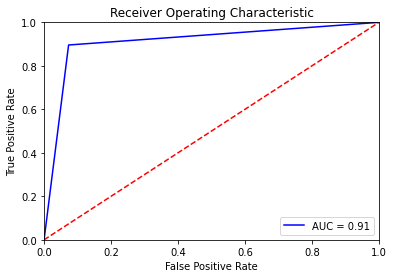

label: severe_toxic
AUC: 0.7092
Accuracy: 99.28%


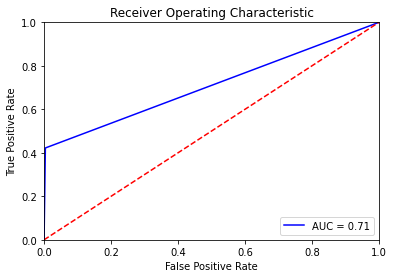

label: obscene
AUC: 0.8870
Accuracy: 96.00%


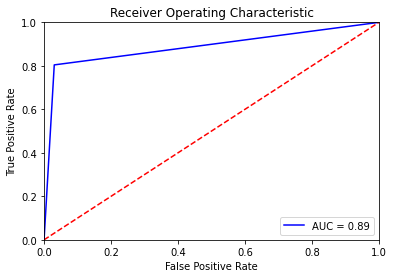

label: threat
AUC: 0.7908
Accuracy: 99.72%


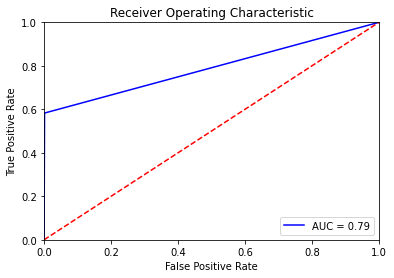

label: insult
AUC: 0.8521
Accuracy: 96.83%


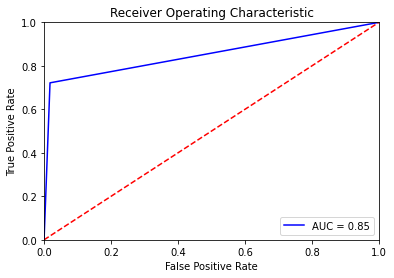

label: identity_hate
AUC: 0.7767
Accuracy: 99.22%


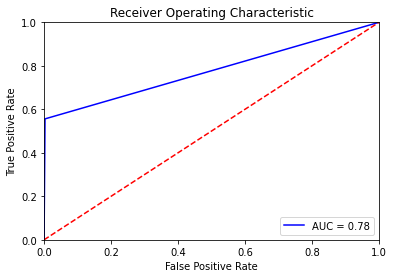

In [23]:
for i, name in enumerate(LABEL_COLUMNS):
    print(f"label: {name}")
    evaluate_roc(test_y_pred[:,i]>0.5, test_y_true[:,i])